In [137]:
from flax import linen as nn 
from flax.linen import initializers
from flax.core import freeze, unfreeze
from flax.linen.module import compact
from basic import logprior_fn, logvariational_fn, samplevariational_fn, sigmas_from_rhos
from typing import (Any, Callable, Iterable, List, Optional, Sequence, Tuple,
                    Union)
import jax
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as random
from jax import lax
PRNGKey = Any
Shape = Tuple[int, ...]
Dtype = Any  # this could be a real type?
Array = Any
default_kernel_init = initializers.lecun_normal()
from jax.random import PRNGKey, split
import optax

In [166]:
class BNNLayer(nn.Module):

    features: int
    prior_pi: float
    prior_var1: float
    prior_var2: float
    parameter_init: Callable = nn.initializers.lecun_normal()

    @compact
    def __call__(self, sampling_key: random.PRNGKey, inputs, n_samples: int):
        # Variational Parameters
        mus = self.param(
            "mus", 
            self.parameter_init, 
            (jnp.shape(inputs)[-1] + 1, self.features)) # +1 for bias
        rhos = self.param(
            "rhos",
            self.parameter_init,
            (jnp.shape(inputs)[-1] + 1, self.features) # +1 for bias
        )

        # Sample weights
        weights_and_biases = samplevariational_fn(
            mus=mus,
            rhos=rhos,
            key=sampling_key,
            n_samples=n_samples
        )

        weights = jnp.mean(weights_and_biases, axis=0)[:-1]
        biases = jnp.mean(weights_and_biases, axis=0)[-1]

        

        y = jnp.dot(inputs, weights) + biases

        # Compute terms for KL penalty
        # Need to copy and stack due to multiple samples for weights.
        stacked_mus = jnp.stack((mus,) * n_samples, axis=0)
        stacked_rhos = jnp.stack((rhos,) * n_samples, axis=0)
        log_variational_density = logvariational_fn(
            weights=weights,
            mus=stacked_mus,
            rhos=stacked_rhos,
        )
        log_prior_density = logprior_fn(
            weights=weights,
            pi=self.prior_pi,
            var1=self.prior_var1,
            var2=self.prior_var2,
        )
        return y, log_variational_density, log_prior_density



In [167]:
# from jax.random import split , PRNGKey

# key = PRNGKey(123)


# key, subkey = split(key)
# x = random.uniform(subkey, (1,1))
# model = BNNLayer(features=1, prior_pi=0.5, prior_var1=0.9, prior_var2=0.01)


# key, rng = split(key)
# key, sampling_key = split(key)
# params = model.init(
#     rngs=rng, 
#     sampling_key=sampling_key,  
#     inputs=x, 
#     n_samples=1)

# key, subkey = split(key)
# out, log_variational_density, log_prior_density = model.apply(params, subkey, x, 1)


# # Likelihood loss functions
# def categorical_nll(logits, y):
#     num_classes = logits.shape[-1]
#     labels = jax.nn.one_hot(y, num_classes)
#     return -jnp.sum(labels * jax.nn.log_softmax(logits))

# def mse(params, model_apply, x, y):
#     logits = model_apply(params, subkey, x, 1)[0]
#     return jnp.mean((logits - y)**2)

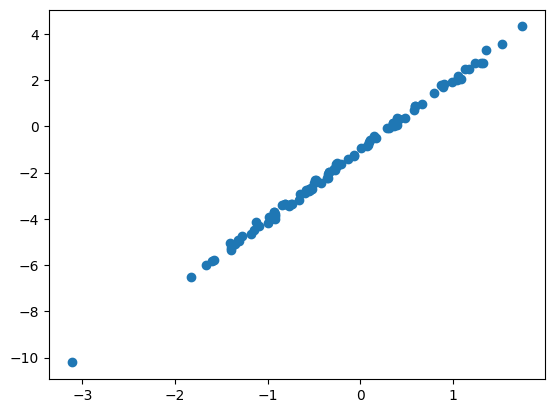

In [168]:
import numpy as np

xs = np.random.normal(size=(100,1))
noise = np.random.normal(scale=0.1, size=(100,1))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys);

In [175]:
# from functools import partial

# @partial(jax.jit, static_argnums=0)
# def elbo(model_apply, params, x, y, rng):
    
#     logits, log_variational_density, log_prior_density = model_apply(params, rng, x, 1)

#     nll = mse(logits, y)
    
#     return nll

# d_elbo = jax.value_and_grad(elbo, argnums=1)

In [176]:
key = PRNGKey(123)

key, subkey = split(key)
key, sampling_key = split(key)
model = BNNLayer(1, 0.5, 0.9, 0.01)
params = model.init(subkey, sampling_key, xs[0], 1)

In [177]:
opt = optax.sgd(learning_rate=0.1)
opt_state = opt.init(params)



def loss_fn(params, model, xs, ys, key):
    key, subkey = split(key)
    logits = model.apply(params, subkey, xs, 1)[0]
    return jnp.mean((logits-ys)**2)


for _ in range(1000):
    key, subkey = split(key)
    grad = jax.grad(loss_fn)(params, model, xs, ys, subkey)
    updates, opt_state = opt.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)

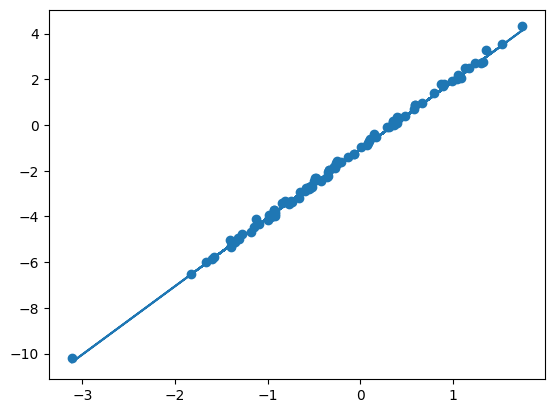

In [178]:
plt.scatter(xs, ys)
plt.plot(xs, model.apply(params, subkey, xs, 1)[0])

In [179]:
print(params)

FrozenDict({
    params: {
        mus: Array([[ 2.992998 ],
               [-1.0155613]], dtype=float32),
        rhos: Array([[-2.8068864],
               [-2.9260924]], dtype=float32),
    },
})


In [180]:
print(samplevariational_fn(params["params"]["mus"], params["params"]["rhos"], key, 1))

[[[ 2.9442854]
  [-1.001548 ]]]
